In [82]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [83]:
raw_folders = ['good 1', 'good 2', 'track 1 normal', 'track 1 reverse', 'track 2 normal']

In [84]:
from utils import extract_file_name

def read_raw_driving_csv(folder: str):
    csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)

    with open(csv_path, 'r') as f:
        return pd.read_csv(
            csv_path,
            header=None,
            names=['center', 'left', 'right', 'steering_angle'],
            usecols=[0, 1, 2, 3],
            converters={
                'center': lambda x: extract_file_name(x),
                'left': lambda x: extract_file_name(x),
                'right': lambda x: extract_file_name(x)
            }
        )


In [85]:
from utils import all_paths_exist

def remove_non_triple_images(raw_folders):
    for folder in raw_folders:
        remove_indexes = []
        print('-- Checking {0}'.format(folder))

        df = read_raw_driving_csv(folder)
        print('DF Before: ', len(df))

        for index, row in df.iterrows():
            image_center_path = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['center'])
            image_left_path = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['left'])
            image_right_path = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['right'])

            # if an image does not exist, remove all images from the same row
            if not all_paths_exist([image_center_path, image_left_path, image_right_path]):
                for path in [image_center_path, image_left_path, image_right_path]:
                    if os.path.exists(path):
                        os.remove(path)

                remove_indexes.append(index)

        df.drop(labels=df.index[remove_indexes], inplace=True)
        print('DF After : ', len(df))

        csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)
        df.to_csv(csv_path, index=False, header=False)

In [86]:
remove_non_triple_images(raw_folders)

-- Checking good 1
DF Before:  10405
DF After :  10405
-- Checking good 2
DF Before:  20882
DF After :  20882
-- Checking track 1 normal
DF Before:  2194
DF After :  2194
-- Checking track 1 reverse
DF Before:  2934
DF After :  2934
-- Checking track 2 normal
DF Before:  1474
DF After :  1474


# Load and Visualize Dataset

In [87]:
full_set = pd.DataFrame()

for folder in raw_folders:
    df = read_raw_driving_csv(folder)
    df['folder'] = folder
    full_set = pd.concat([full_set, df], ignore_index=True)

In [88]:
full_set.dtypes

center             object
left               object
right              object
steering_angle    float64
folder             object
dtype: object

In [89]:
full_set.head()

,center,left,right,steering_angle,folder
0,center_2019_04_02_19_25_35_023.jpg,left_2019_04_02_19_25_35_023.jpg,right_2019_04_02_19_25_35_023.jpg,0.00,good 1
1,center_2019_04_02_19_25_35_092.jpg,left_2019_04_02_19_25_35_092.jpg,right_2019_04_02_19_25_35_092.jpg,-0.15,good 1
2,center_2019_04_02_19_25_35_164.jpg,left_2019_04_02_19_25_35_164.jpg,right_2019_04_02_19_25_35_164.jpg,0.00,good 1
3,center_2019_04_02_19_25_35_232.jpg,left_2019_04_02_19_25_35_232.jpg,right_2019_04_02_19_25_35_232.jpg,0.00,good 1
4,center_2019_04_02_19_25_35_303.jpg,left_2019_04_02_19_25_35_303.jpg,right_2019_04_02_19_25_35_303.jpg,0.00,good 1


In [90]:
full_set.iloc[1]

center            center_2019_04_02_19_25_35_092.jpg
left                left_2019_04_02_19_25_35_092.jpg
right              right_2019_04_02_19_25_35_092.jpg
steering_angle                                 -0.15
folder                                        good 1
Name: 1, dtype: object

In [91]:
full_set.iloc[1]['folder']

'good 1'

In [92]:
full_set['steering_angle'][1]

-0.15

# Balance the Dataset

In [93]:
num_bins = 21
samples_per_bin = 1400

In [94]:
def show_steering_angles(full_set, hist, bins, samples_per_bin):
    center = (bins[:-1] + bins[1:]) * 0.5
    plt.bar(center, hist, width=0.05)
    plt.plot(
        (np.min(full_set['steering_angle']), np.max(full_set['steering_angle'])),
        (samples_per_bin, samples_per_bin)
    )

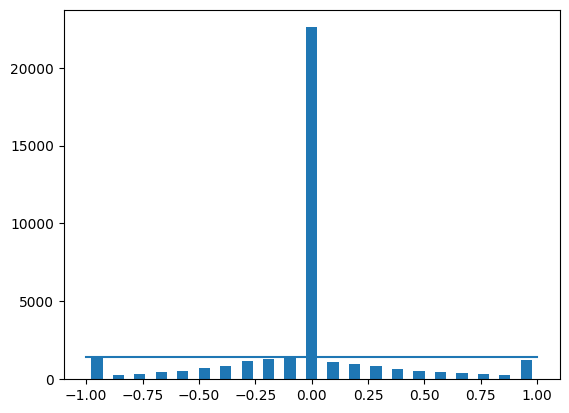

In [95]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

In [96]:
print('total data:', len(full_set))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(full_set['steering_angle'])):
    if bins[j] <= full_set['steering_angle'][i] <= bins[j + 1]:
      list_.append(i)

  random.shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
full_set.drop(full_set.index[remove_list], inplace=True)
print('remaining:', len(full_set))

total data: 37889
removed: 21257
remaining: 16632


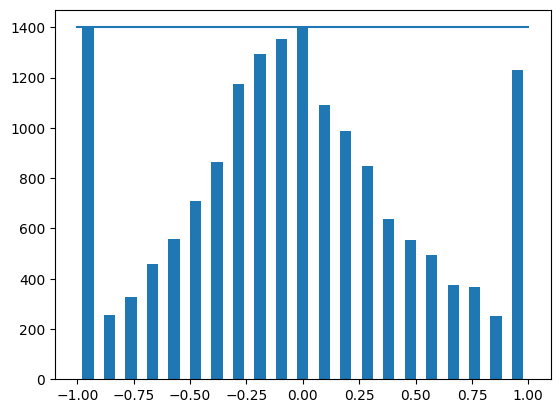

In [97]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

# Split the CSV

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(full_set, train_size=0.9, shuffle=True)

In [58]:
len(full_set), len(X_train), len(X_test)

(15952, 14356, 1596)

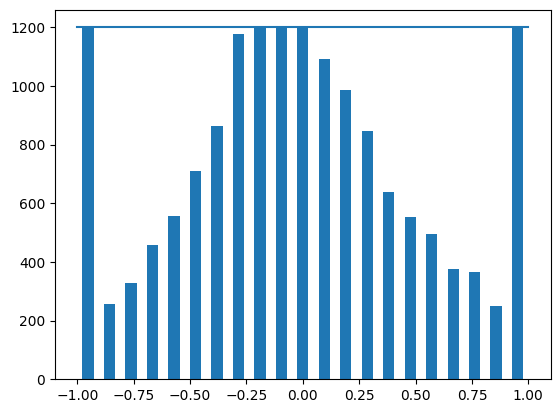

In [59]:
show_steering_angles(X_train, hist, bins, samples_per_bin)

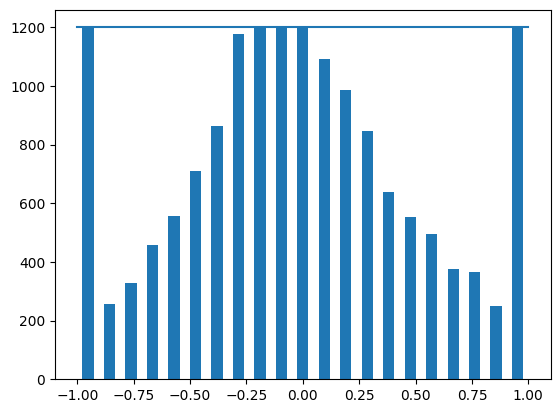

In [60]:
show_steering_angles(X_test, hist, bins, samples_per_bin)

In [61]:
X_train.head()

,center,left,right,steering_angle,folder
10524,center_2019_04_02_18_05_47_271.jpg,left_2019_04_02_18_05_47_271.jpg,right_2019_04_02_18_05_47_271.jpg,0.00000,good 2
35690,center_2023_04_28_21_10_38_723.jpg,left_2023_04_28_21_10_38_723.jpg,right_2023_04_28_21_10_38_723.jpg,0.08627,track 1 reverse
11599,center_2019_04_02_18_07_06_320.jpg,left_2019_04_02_18_07_06_320.jpg,right_2019_04_02_18_07_06_320.jpg,-0.20000,good 2
14823,center_2019_04_02_18_10_51_472.jpg,left_2019_04_02_18_10_51_472.jpg,right_2019_04_02_18_10_51_472.jpg,0.90000,good 2
13799,center_2019_04_02_18_09_39_945.jpg,left_2019_04_02_18_09_39_945.jpg,right_2019_04_02_18_09_39_945.jpg,-0.05000,good 2


# Preprocess Images

In [104]:
import os, shutil

def clear_folder(folder):
    for files in os.listdir(folder):
        path = os.path.join(folder, files)
        try:
            shutil.rmtree(path)
        except OSError:
            os.remove(path)


In [105]:
from torchvision.io import read_image
from PIL import Image
from utils import preprocess

PREPROCESSED_FOLDER = '.\\data\\preprocessed\\'

def preprocess_and_store_images(df, stage='train'):
    clear_folder(PREPROCESSED_FOLDER + stage)
    # os.mkdir(PREPROCESSED_FOLDER + stage)

    for index, row in df.iterrows():
        folder = row['folder']

        for image_name in ['center', 'left', 'right']:
            image_name = row[image_name]
            raw_path = '.\\data\\raw\\' + folder + '\\IMG\\' + image_name

            if not os.path.exists(raw_path):
                continue

            image = read_image(raw_path)
            # print('Original Shape : ', image.shape)
            image = preprocess(image)
            # print('New Shape : ', image.shape)
            # print(image[0, 0, :10])

            path = '{}\\{}\\{}'.format(PREPROCESSED_FOLDER, stage, image_name)
            Image.fromarray(image.numpy().transpose(1, 2, 0)).save(path)

In [106]:
preprocess_and_store_images(X_train, 'train')
preprocess_and_store_images(X_test, 'test')

# Save CSV

In [107]:
X_train.to_csv(
    '.\\data\\preprocessed\\driving_train_log.csv',
    index=False,
    columns=['center', 'left', 'right', 'steering_angle']
)

X_test.to_csv(
    '.\\data\\preprocessed\\driving_test_log.csv',
    index=False,
    columns=['center', 'left', 'right', 'steering_angle']
)